# Link Prediction on the Amazon Co-Purchase Graph with GNNs

## Data and Problem Statement - Overview

In this project, I want to explore the use of Graph Neural Networks (GNNs) to model structural relationships in a real-world. I use the Amazon product co-purchasing network and ground-truth communities data on the SNAP repository (link - https://snap.stanford.edu/data/com-Amazon.html)

A summary of the data:

- This data is based on the "Customers Who Bought This Item Also Bought" feature that we see on the Amazon website.
- Each node is an Amazon product. 
- An edge in this graph defines how often a product i has been co-purchased with product j - hence defining product-product relationships. 
- There is also the concept of a "community" for this graph, where each product's category provided in the Amazon catalog is a ground-truth community. Data at this level can also help us understand things that form at a community level.


The core task that I want to focus on is **link prediction**:

- Given two products, is there a way where we predict whether they should be connected in the co-purchase graph? 
- This is a classic problem in recommendation systems in e-commerce.
- A large part of this graph can be unseen product pairs. There might be a lot of products across these different categories / communities, indicating sparsity (as we will see). 
- This approach will allows us to evaluate how well structural graph patterns can guide suggestions for these unseen product pairs.


Modern recommendation systems focus heavily on how users interact with products in the catalog based on their view / add to cart / purchase patterns, and various other relevant signals that can be interpreted based on their activity on the e-commerce platform. By looking at product-product relationships through a graphical structure, we can gain underlying insights on questions like the following:

- Are there specific dominant products (or) communities of products that are linked? How are they connected and how similar are they?
- How expressive would node embeddings be by just considering the co-purchase context?
- How representative can this data / a model trained on this data be to power recommendation algorithms?


## Notebook Structure


**Exploring the Amazon co-purchase data**: Parse and visualize the Amazon co-purchase graph. 

- Obtain high-level insights from the graph.
- Create the community subgraph, analyse different communities and analyse the community subgraph in comparison to the original overall graph.
- Provide reasoning to constrain the problem to the community subgraph.
- Analyze properties statistics such as degree distributions, component sizes, clustering, and community structure.

# Imports

In [29]:
import gzip
import json
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
import seaborn as sns

from collections import Counter
from matplotlib.lines import Line2D

# Exploring the Amazon co-purchase dataset

### Loading the graph data & summarizing basic overall graph statistics


- Let us try to understand the properties of our co-purchase graph - to get an idea of how densely the products are connected and whether any global patterns emerge.

- Below, we compute and summarize basic statistics of the graph, including the number of nodes and edges, average degree, graph density, clustering coefficient, and details about connectivity. 

<!-- These statistics not only help validate data quality but also guide how we construct models—for instance, sparse graphs with strong clustering may benefit from localized message passing in GNNs. -->

<!-- The **largest connected component** is particularly important, as GNNs rely on connectivity for message propagation. We'll focus our modeling efforts on this component to ensure meaningful learning. -->


In [2]:
def load_graph(file_path):
    edges = []
    with gzip.open(file_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return nx.Graph(edges)


def basic_graph_stats(G):

    number_of_nodes = G.number_of_nodes()
    number_of_edges = G.number_of_edges()
    degrees = dict(G.degree()).values()

    stats = {
        "Number of nodes": number_of_nodes,
        "Number of edges": number_of_edges,
        "Average degree": sum(degrees) / number_of_nodes if number_of_nodes > 0 else 0,
        "Density": nx.density(G),
        "Average clustering coefficient": nx.average_clustering(G),
        "Number of connected components": nx.number_connected_components(G),
        "Size of largest component": (
            len(max(nx.connected_components(G), key=len)) if number_of_nodes > 0 else 0
        ),
    }
    return stats

In [3]:
graph = load_graph(file_path="data/raw/com-amazon.ungraph.txt.gz")
print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

stats = basic_graph_stats(graph)
print("\n\n\n*** OVERALL GRAPH STATISTICS ***\n")
print(json.dumps(stats, indent=4))

Graph has 334863 nodes and 925872 edges.



*** OVERALL GRAPH STATISTICS ***

{
    "Number of nodes": 334863,
    "Number of edges": 925872,
    "Average degree": 5.529855493141971,
    "Density": 1.6513834036534368e-05,
    "Average clustering coefficient": 0.3967463932787655,
    "Number of connected components": 1,
    "Size of largest component": 334863
}


#### High-level Insights:


- The statistics suggests that each product is co-purchased with 5–6 others on average, which is low in comparison to the overall number of products, and is typical purchase pattern in such platforms. 

- These 5-6 products that are linked are either similar category or something that complements each other. 

    - For example, {phone, phone-case, screen-protector} (or) {PS5, additional controller, charger for controllers} might be purchased together as they are contextually related and purchasing them together enhances the usability of the phone or the PS5. 
    - Another example could be {shampoo, conditioner, hair wax} - all same category and can be likely purchased together because someone wants to invest in hair products.

- The graph is **extremely sparse** - a major chunk of products are not linked, as it should be.

    - Links only exist for contextually similar or categorically similar products as seen above. 
    - The whole category has over 300k products and not every product is contextually related.

- The average clustering coefficient of this graph is around ~0.4 and this is quite high for such a sparse graph. 

    - This means that there are some strong local communities.
    - If a product A is co-purchased with B and C, then B and C are also very likely co-purchased with each other.

- The graph is fully connected - there is a path that connects each product to every other via some sequence of co-purchases.

These statistics confirm that the Amazon co-purchase graph exhibits **small-world properties** -  high local clustering and global connectivity (one connected component despite sparsity).


### Community graph - High level Insights:

- Each “community” in the dataset is defined as a connected component within a specific product category. 

- These groups reflect semantically coherent product clusters — such as books, electronics, or clothing — where intra-community interactions (e.g., co-purchases) are dense and meaningful.

In [7]:
filepath = "data/raw/com-amazon.all.dedup.cmty.txt.gz"
all_cmty_nodes = set()
with gzip.open(filepath, "rt") as f:
    line_count = sum(1 for _ in f)

print(f"Total communities in file: {line_count}")

# Viewing sample records in file
with gzip.open(filepath, "rt") as f:
    for i in range(5):
        line = f.readline()
        print(f"Line {i}: '{line.strip()}'")

Total communities in file: 75149
Line 0: '100005	127545	202036	257630	362970	376927	429080'
Line 1: '10001	27638	51569	88226	116422	126227	159947	162938	184977	188045	191044	246142	265214	290507	296858	300258	341525	348922	359832	365744	382502	390538	410857	433453	479170	489980	540746'
Line 2: '10001	27638	51569	88226	116422	126227	159947	162938	184977	188045	191044	246142	265214	290507	300258	341525	348922	359832	365744	382502	390538	410857	433453	479170	489980	540746'
Line 3: '100017	118111	263647	268405	315862'
Line 4: '100020	267700	301658	376628	410518	464375'


In [8]:
filepath = "data/raw/com-amazon.top5000.cmty.txt.gz"
all_cmty_nodes = set()
with gzip.open(filepath, "rt") as f:
    line_count = sum(1 for _ in f)

print(f"Total communities in the 5k file: {line_count}")

# Viewing sample records in file
with gzip.open(filepath, "rt") as f:
    for i in range(5):
        line = f.readline()
        print(f"Line {i}: '{line.strip()}'")

Total communities in the 5k file: 5000
Line 0: '164985	225214	232761'
Line 1: '105089	282815	331787'
Line 2: '167906	288975	421279	442612	451312'
Line 3: '69880	231953	518997	523128'
Line 4: '135499	160294	304770'


In [9]:
def extract_top_communities_subgraph(G, community_path):
    community_map = {}
    community_id = 0

    with gzip.open(community_path, "rt") as f:
        for line in f:
            nodes = list(map(int, line.strip().split("\t")))
            for node in nodes:
                if node in G and node not in community_map:
                    community_map[node] = community_id
            community_id += 1

    selected_nodes = set(community_map.keys())
    G_sub = G.subgraph(selected_nodes).copy()

    return G_sub, community_map

In [10]:
_, entire_community_map = extract_top_communities_subgraph(
    graph, community_path="data/raw/com-amazon.all.dedup.cmty.txt.gz"
)


top_k_community_graph, top_k_community_map = extract_top_communities_subgraph(
    graph, community_path="data/raw/com-amazon.top5000.cmty.txt.gz"
)
print(
    f"Top-5000 community subgraph has {top_k_community_graph.number_of_nodes()} nodes and {top_k_community_graph.number_of_edges()} edges."
)

top_k_community_stats = basic_graph_stats(top_k_community_graph)
print("\n\n\n*** TOP-K COMMUNITY GRAPH STATISTICS ***\n")
print(json.dumps(top_k_community_stats, indent=4))

Top-5000 community subgraph has 16716 nodes and 48739 edges.



*** TOP-K COMMUNITY GRAPH STATISTICS ***

{
    "Number of nodes": 16716,
    "Number of edges": 48739,
    "Average degree": 5.831418999760708,
    "Density": 0.00034887340710503786,
    "Average clustering coefficient": 0.6488186833732773,
    "Number of connected components": 1106,
    "Size of largest component": 475
}


- The top-5000 community subgraph retains similar local structural properties - statistics such as average degree and clustering behavior is the same

-  The difference is visible in the global structure - the subgraph is far denser and highly fragmented as there are many disconnected components. 

- Each top community is very densely connected internally but poorly connected externally, which was something that we observed in the overall graph.

- If we only consider products that only belong to top-5000 communities, then we are not considering edges that go from the top-5000 communities to other products that are not part of the top-5000 communities. Those bridge edges are lost here.

**Let us try to include the bridge edges for all the nodes and analyse again.**

In [12]:
# Rewriting this function - to include outward edges


def extract_top_communities_subgraph(G, community_path):

    community_map = {}
    community_id = 0

    # Read top-k communities and build the node set
    with gzip.open(community_path, "rt") as f:
        for line in f:
            nodes = list(map(int, line.strip().split("\t")))
            for node in nodes:
                if node in G and node not in community_map:
                    community_map[node] = community_id
            community_id += 1

    top_k_nodes = set(community_map.keys())

    # Include all edges where at least one node is in top-k
    expanded_edges = [
        (u, v) for u, v in G.edges() if u in top_k_nodes or v in top_k_nodes
    ]

    # Build the new graph
    G_expanded = nx.Graph()
    G_expanded.add_edges_from(expanded_edges)

    return G_expanded, community_map

In [13]:
top_k_community_expanded_graph, top_k_community_expanded_map = (
    extract_top_communities_subgraph(graph, "data/raw/com-amazon.top5000.cmty.txt.gz")
)

print(
    f"Top-5000 expanded subgraph has {top_k_community_expanded_graph.number_of_nodes()} nodes and {top_k_community_expanded_graph.number_of_edges()} edges"
)

top_k_community_expanded_stats = basic_graph_stats(top_k_community_expanded_graph)
print("\n\n\n*** TOP-K COMMUNITY EXPANDED GRAPH STATISTICS ***\n")
print(json.dumps(top_k_community_expanded_stats, indent=4))

Top-5000 expanded subgraph has 19905 nodes and 53780 edges



*** TOP-K COMMUNITY EXPANDED GRAPH STATISTICS ***

{
    "Number of nodes": 19905,
    "Number of edges": 53780,
    "Average degree": 5.403667420246169,
    "Density": 0.0002714865062422714,
    "Average clustering coefficient": 0.5384229737133063,
    "Number of connected components": 1044,
    "Size of largest component": 481
}


| Metric                 | Top-5000 Only | Expanded Version     | Interpretation                                               |
| ---------------------- | ------------- | -------------------- | ------------------------------------------------------------ |
| Nodes                  | 16,716        | 19,905               | +3.2k bridge nodes added                                     |
| Edges                  | 48,739        | 53,780               | \~5k new edges, mostly community-to-outside                  |
| Avg. Degree            | 5.83          | 5.40                 | Slight drop, expected since bridges dilute dense intra-links |
| Density                | 0.00035       | 0.00027              | Slightly lower — again expected due to bridge sparsity       |
| Avg. Clustering Coeff. | 0.65          | 0.54                 | Drop shows that bridge nodes are less clustered              |
| Connected Components   | 1106          | 1044                 | Slight improvement in connectivity                           |
| Largest Component Size | 475           | 481                  | Marginal increase                                            |

- There are around ~5k new edges added and all of these are bridge edges, which add important context of co-purchasing patterns.

- The average degree distribution is still consistent, and the clustering coefficient slightly drops and is now closer to the distributions in the overall graph.

- Fragmentation has slightly reduced because of the introduction to the bridge edges.


We can use the expanded version of the top_k community graph because:

- The average clustering coefficient in this subset is 0.54, much higher than the full graph (0.39), indicating stronger local cohesion

- Though this subset includes only ~5% of all nodes, it captures a significant portion of useful interaction patterns due to high internal density.

- Hence we can constrain the problem to **predict future or missing co-purchase links between products within and near top-5000 communities**.

- Here, **near** comes from past interactions (we included some links from top_k to non-top_k nodes)


### Structural Analysis on the subgraph

- Analyzing community structure helps reveal more information about graph relationships. 

- It can convey information about how consumers navigate the catalog, whether they buy within or across contexts and categories, and what kind of structural patterns govern co-purchases.

In [14]:
def degree_distribution_plot(G):
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=100, log=True)
    plt.xlabel("Node Degree")
    plt.ylabel("Frequency (log)")
    plt.title("Degree Distribution")

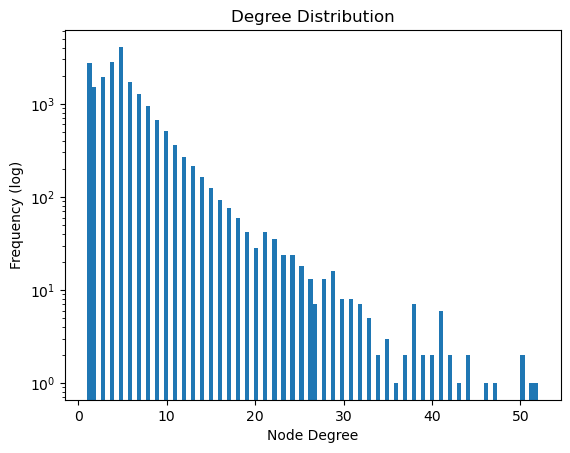

In [15]:
degree_distribution_plot(top_k_community_expanded_graph)

- The degree distribution follows a **long-tail pattern** - consistent with a power-law or **scale-free network**. Most nodes have low degree (1–5), while a few nodes are high-degree hubs with 30+ connections.

- The log-scale frequency confirms that a small number of products dominate the co-purchase network.

In [16]:
def size_density_plot(G, community_map):

    density_by_comm = {}
    for cid in set(community_map.values()):
        nodes = [n for n, c in community_map.items() if c == cid]
        subg = G.subgraph(nodes)
        density_by_comm[cid] = nx.density(subg)

    # Plot size vs. density
    import matplotlib.pyplot as plt

    sizes = [
        len([n for n in community_map if community_map[n] == cid])
        for cid in density_by_comm
    ]
    densities = list(density_by_comm.values())

    plt.scatter(sizes, densities, alpha=0.5)
    plt.xlabel("Community Size")
    plt.ylabel("Internal Edge Density")
    plt.title("Community Size vs Density")

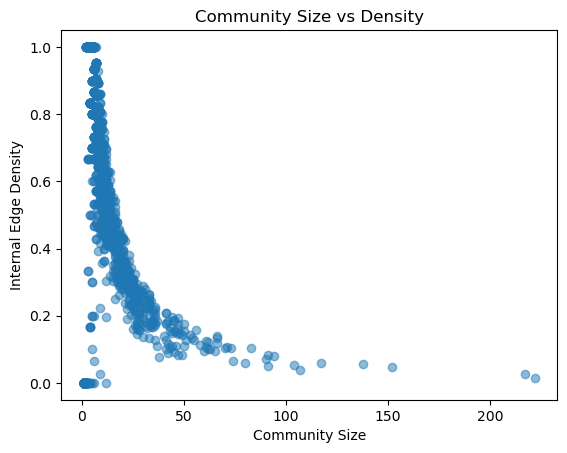

In [17]:
size_density_plot(top_k_community_expanded_graph, top_k_community_expanded_map)

In [18]:
def community_size_distribution_plot(community_map):
    community_sizes = Counter(community_map.values())
    sns.histplot(list(community_sizes.values()), bins=50)

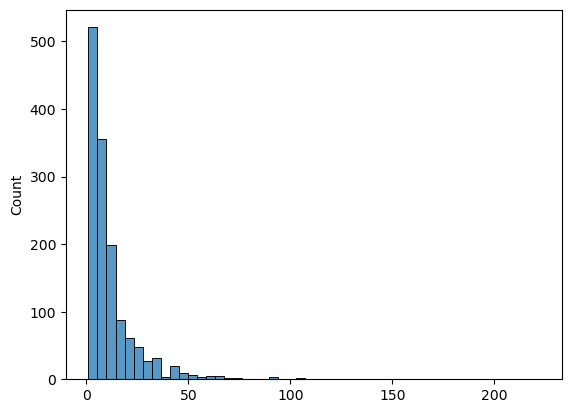

In [19]:
community_size_distribution_plot(top_k_community_expanded_map)

- There is a inverse relationship between community size and internal edge density. Small communities (≤ 20 nodes) often have very high densities, which likely represent tightly interconnected product bundles.

- As community size increases, density rapidly drops, indicating that larger communities are more diffuse and possibly span multiple subcategories or product types.

- This shows that small, niche categories are highly cohesive, possibly representing co-purchase sets.

In [20]:
def bridge_ratio_plot(G, community_map):

    bridge_ratios = {}
    for cid in set(community_map.values()):
        comm_nodes = set(n for n, c in community_map.items() if c == cid)
        internal_edges = 0
        bridge_edges = 0
        for node in comm_nodes:
            for neighbor in G.neighbors(node):
                if neighbor in comm_nodes:
                    internal_edges += 1
                else:
                    bridge_edges += 1
        total_edges = internal_edges + bridge_edges
        bridge_ratios[cid] = bridge_edges / total_edges if total_edges > 0 else 0

    # Histogram of bridge ratios
    plt.hist(list(bridge_ratios.values()), bins=20, edgecolor="black")
    plt.xlabel("Bridge Ratio")
    plt.ylabel("Frequency")
    plt.title("Bridge Ratio Distribution")
    plt.show()

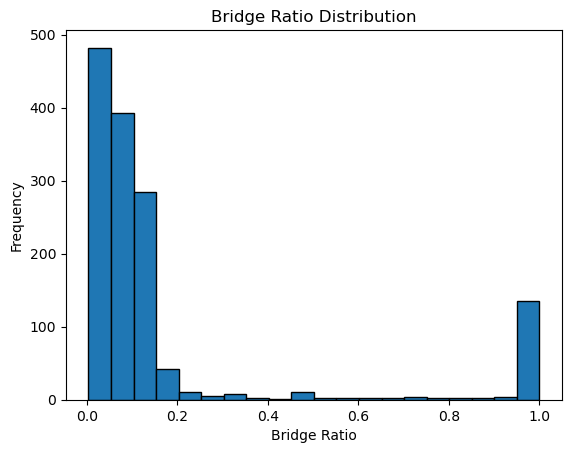

In [21]:
bridge_ratio_plot(top_k_community_expanded_graph, top_k_community_expanded_map)

- The majority of communities have low bridge ratios (< 0.2), indicating that most edges are internal. We could see this when expanding only gave 5k more edges.

- A few have a bridge ratio close to 1, meaning nearly all edges connect to other communities.

In [22]:
def obtain_largest_connected_component(graph):
    lcc_nodes = max(nx.connected_components(graph), key=len)
    lcc = top_k_community_expanded_graph.subgraph(lcc_nodes).copy()
    return lcc

In [23]:
top_k_community_expanded_graph_lcc = obtain_largest_connected_component(
    top_k_community_expanded_graph
)
print(
    f"Top-5000 expanded subgraph LCC has {top_k_community_expanded_graph_lcc.number_of_nodes()} nodes and {top_k_community_expanded_graph_lcc.number_of_edges()} edges"
)

top_k_community_expanded_lcc_stats = basic_graph_stats(
    top_k_community_expanded_graph_lcc
)
print("\n\n\n*** TOP-K COMMUNITY LARGEST CONNECTED COMPONENT STATISTICS ***\n")
print(json.dumps(top_k_community_expanded_lcc_stats, indent=4))

Top-5000 expanded subgraph LCC has 481 nodes and 1193 edges



*** TOP-K COMMUNITY LARGEST CONNECTED COMPONENT STATISTICS ***

{
    "Number of nodes": 481,
    "Number of edges": 1193,
    "Average degree": 4.960498960498961,
    "Density": 0.010334372834372834,
    "Average clustering coefficient": 0.4167648807205847,
    "Number of connected components": 1,
    "Size of largest component": 481
}


- We find that the largest connected component (LCC) consists of only 481 nodes, which accounts for approximately 2.4% of the total nodes in the subgraph. This means that the graph is highly fragmented, comprising over 1,000 disconnected components

- Many of these components are dense, self-contained clusters with high internal connectivity and strong local structure which correspond to coherent product communities.

- When we train on the expanded subgraph, we train on multiple such components. GNN message passing will be limited to within-component neighborhoods, but the model still learns shared parameters across all components.

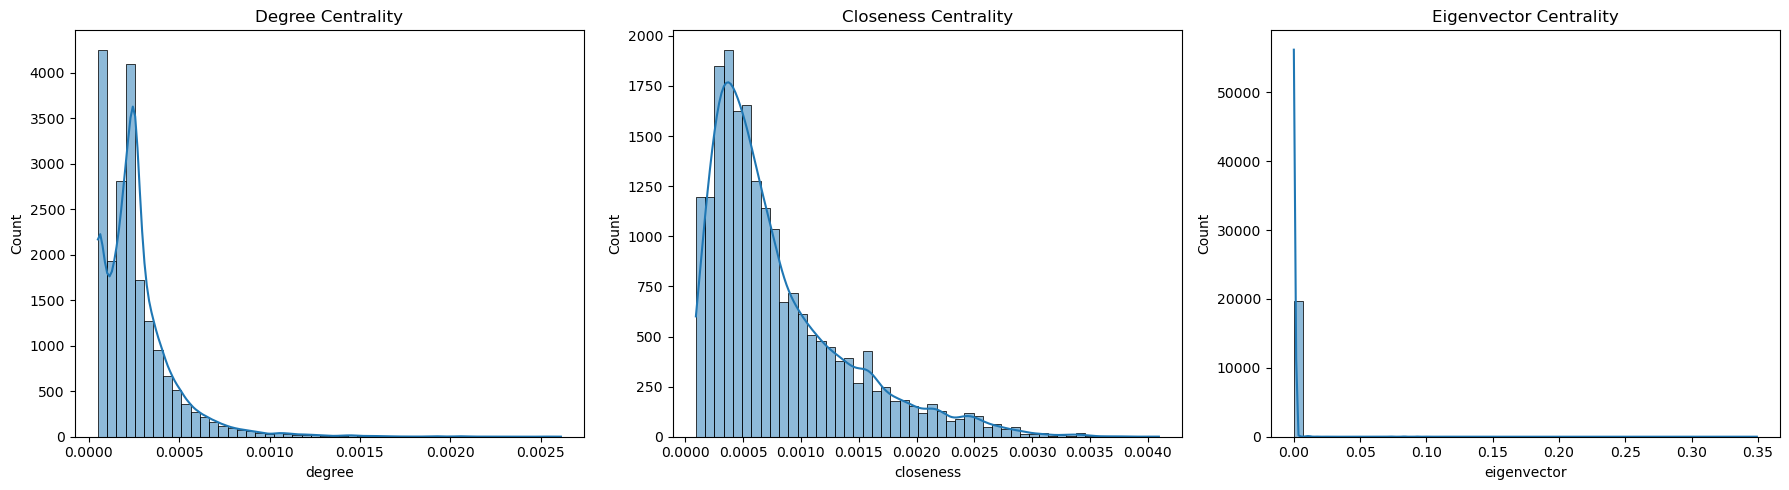

In [ ]:
degree_centrality = nx.degree_centrality(top_k_community_expanded_graph)
closeness_centrality = nx.closeness_centrality(top_k_community_expanded_graph)
eigenvector_centrality = nx.eigenvector_centrality(
    top_k_community_expanded_graph, max_iter=500, tol=1e-6
)

# Betweenness centrality - taking too long to run, commenting it for now
# betweenness_centrality = nx.betweenness_centrality(top_k_community_expanded_graph, k=1000, seed=42)

centrality_df = pd.DataFrame(
    {
        "node": list(degree_centrality.keys()),
        "degree": list(degree_centrality.values()),
        "closeness": [closeness_centrality[n] for n in degree_centrality],
        "eigenvector": [eigenvector_centrality.get(n, 0.0) for n in degree_centrality],
    }
)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(centrality_df["degree"], bins=50, ax=axs[0], kde=True)
axs[0].set_title("Degree Centrality")

sns.histplot(centrality_df["closeness"], bins=50, ax=axs[1], kde=True)
axs[1].set_title("Closeness Centrality")

sns.histplot(centrality_df["eigenvector"], bins=50, ax=axs[2], kde=True)
axs[2].set_title("Eigenvector Centrality")

plt.tight_layout()
plt.show()

- Most nodes have very low degree centrality, indicating they are connected to only a few others. A small number of nodes have relatively higher degrees which indicate frequently co-purchased products.

- The closeness centrality has a slightly broader spread but it is still heavily skewed toward lower values. The network has many peripheral nodes with limited global reach.

- Most nodes have near-zero eigenvector centrality. This is because the network has highly localized influence

### Graph Visualizations

Number of nodes in the graph: 334863


/Users/manavrajivmoorthy/miniconda3/envs/conda-env/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


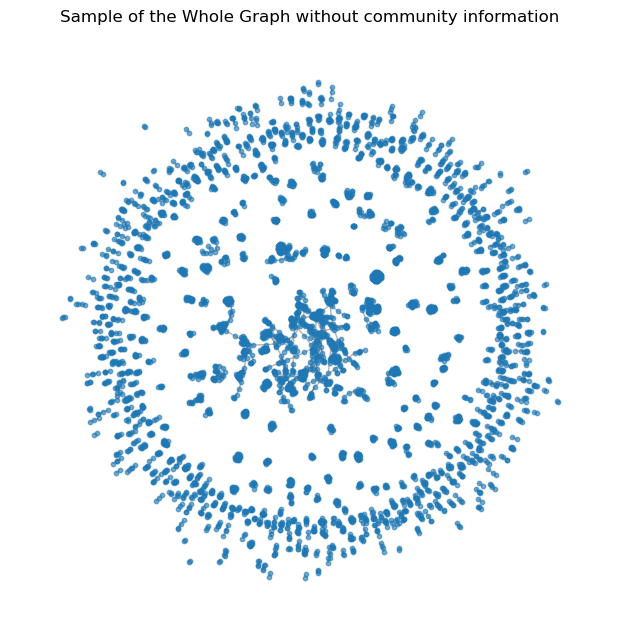

In [60]:
print(f"Number of nodes in the graph: {graph.number_of_nodes()}")
nodes_sampled = list(graph.nodes)[:5000]
G_sample = graph.subgraph(nodes_sampled)
pos = nx.spring_layout(G_sample, seed=42)

plt.figure(figsize=(6, 6))
nx.draw(
    G_sample,
    pos=pos,
    node_size=10,
    cmap=plt.cm.tab20,
    with_labels=False,
    edge_color="gray",
    alpha=0.6,
)

plt.title("Sample of the Whole Graph without community information")
plt.axis("off")
plt.show()

Number of nodes in the graph: 19905


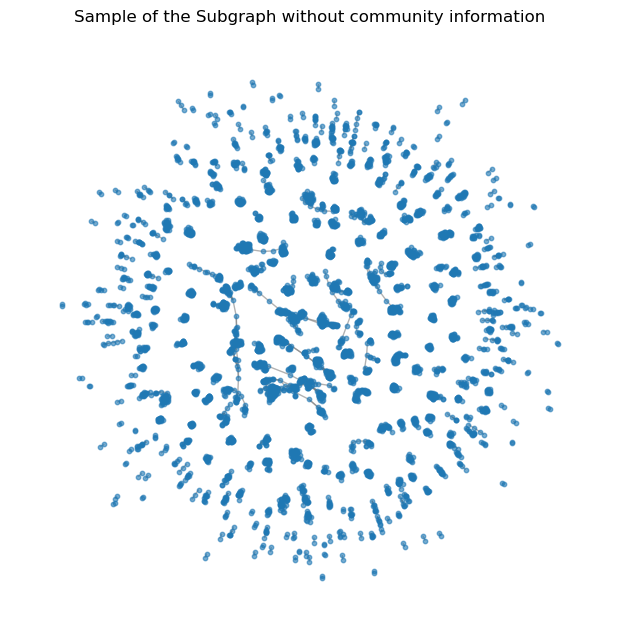

In [64]:
print(
    f"Number of nodes in the graph: {top_k_community_expanded_graph.number_of_nodes()}"
)
nodes_sampled = list(top_k_community_expanded_graph.nodes)[:5000]
G_sample = top_k_community_expanded_graph.subgraph(nodes_sampled)
pos = nx.spring_layout(G_sample, seed=42)

plt.figure(figsize=(6, 6))
nx.draw(
    G_sample, pos=pos, node_size=10, with_labels=False, edge_color="gray", alpha=0.6
)

plt.title("Sample of the Subgraph without community information")
plt.axis("off")
plt.show()

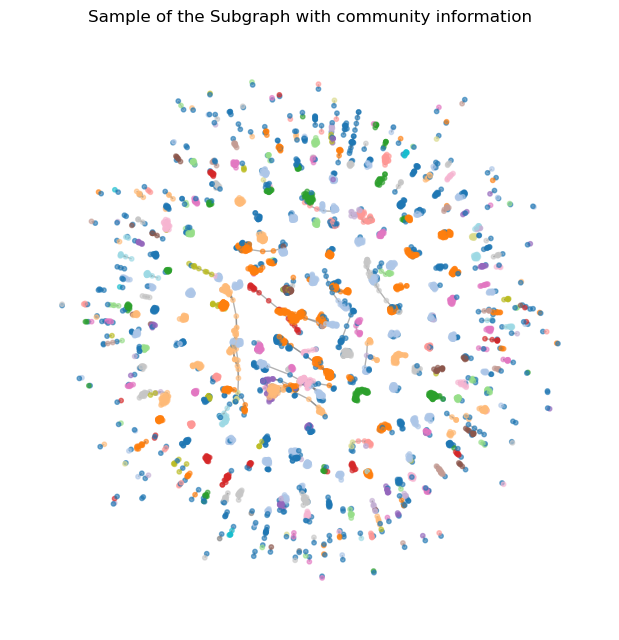

In [65]:
community_colors = [top_k_community_expanded_map.get(n, -1) for n in G_sample.nodes]

plt.figure(figsize=(6, 6))
nx.draw(
    G_sample,
    pos=pos,
    node_size=10,
    node_color=community_colors,
    cmap=plt.cm.tab20,
    with_labels=False,
    edge_color="gray",
    alpha=0.6,
)

plt.title("Sample of the Subgraph with community information")
plt.axis("off")
plt.show()

### What metadata do we have? Creating the metadata df and exploring it

#### Older code

In [41]:
def parse_amazon_meta_gz(path):
    metadata = {}
    current_id = None

    with gzip.open(path, "rt", encoding="latin-1") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if i < 30:
                print(line)
            if line.startswith("Id:"):
                current_id = int(line.split("Id:")[1].strip())
                metadata[current_id] = {}
            elif line.startswith("ASIN:") and current_id is not None:
                metadata[current_id]["asin"] = line.split("ASIN:")[1].strip()
            elif line.startswith("title:") and current_id is not None:
                metadata[current_id]["title"] = line.split("title:")[1].strip()
            elif line.startswith("group:") and current_id is not None:
                metadata[current_id]["group"] = line.split("group:")[1].strip()
            elif line.startswith("salesrank:") and current_id is not None:
                try:
                    metadata[current_id]["salesrank"] = int(
                        line.split("salesrank:")[1].strip()
                    )
                except ValueError:
                    metadata[current_id]["salesrank"] = None

    df = (
        pd.DataFrame.from_dict(metadata, orient="index")
        .reset_index()
        .rename(columns={"index": "id"})
    )
    return df

In [42]:
metadata_df = parse_amazon_meta_gz("data/raw/amazon-meta.txt.gz")

# Full information about Amazon Share the Love products
Total items: 548552

Id:   0
ASIN: 0771044445
discontinued product

Id:   1
ASIN: 0827229534
title: Patterns of Preaching: A Sermon Sampler
group: Book
salesrank: 396585
similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X
categories: 2
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]
reviews: total: 2  downloaded: 2  avg rating: 5
2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9
2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5

Id:   2
ASIN: 0738700797
title: Candlemas: Feast of Flames
group: Book
salesrank: 168596
similar: 5  0738700827  1567184960  1567182836  0738700525  0738700940
categories: 2
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484]
|Book

In [36]:
metadata_df

,id,asin,title,group,salesrank
0,0,0771044445,NaN,NaN,NaN
1,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585.0
2,2,0738700797,Candlemas: Feast of Flames,Book,168596.0
3,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652.0
4,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289.0
...,...,...,...,...,...
548547,548547,B000059TOC,The Drifter,DVD,0.0
548548,548548,B00006JBIX,The House Of Morecock,DVD,0.0
548549,548549,0879736836,Catholic Bioethics and the Gift of Human Life,Book,0.0
548550,548550,B00008DDST,"1, 2, 3 Soleils: Taha, Khaled, Faudel",DVD,0.0


In [39]:
metadata_df["group"].value_counts(dropna=False)

group
Book            393561
Music           103144
Video            26131
DVD              19828
NaN               5868
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: count, dtype: int64

#### Newer code

In [43]:
def parse_amazon_meta_gz_enhanced(path):
    metadata = {}
    current_id = None
    in_categories = False

    with gzip.open(path, "rt", encoding="latin-1") as f:
        for line in f:
            line = line.strip()

            if line.startswith("Id:"):
                current_id = int(line.split("Id:")[1].strip())
                metadata[current_id] = {
                    "asin": None,
                    "title": None,
                    "group": None,
                    "salesrank": None,
                    "categories": [],
                    "avg_rating": None,
                    "num_reviews": None,
                }
                in_categories = False

            elif line.startswith("ASIN:") and current_id is not None:
                metadata[current_id]["asin"] = line.split("ASIN:")[1].strip()

            elif line.startswith("title:") and current_id is not None:
                metadata[current_id]["title"] = line.split("title:")[1].strip()

            elif line.startswith("group:") and current_id is not None:
                metadata[current_id]["group"] = line.split("group:")[1].strip()

            elif line.startswith("salesrank:") and current_id is not None:
                try:
                    metadata[current_id]["salesrank"] = int(
                        line.split("salesrank:")[1].strip()
                    )
                except ValueError:
                    metadata[current_id]["salesrank"] = None

            elif line.startswith("categories:") and current_id is not None:
                in_categories = True
                metadata[current_id]["categories"] = []

            elif in_categories:
                if line == "":
                    in_categories = False
                else:
                    metadata[current_id]["categories"].append(line.strip())

            elif line.startswith("reviews:") and current_id is not None:
                parts = line.split("avg rating:")
                if len(parts) > 1:
                    try:
                        metadata[current_id]["avg_rating"] = float(parts[1].strip())
                    except ValueError:
                        pass
                try:
                    total_part = line.split("total:")[1].split()[0]
                    metadata[current_id]["num_reviews"] = int(total_part)
                except (IndexError, ValueError):
                    pass

    df = (
        pd.DataFrame.from_dict(metadata, orient="index")
        .reset_index()
        .rename(columns={"index": "id"})
    )
    return df

In [45]:
metadata_df = parse_amazon_meta_gz_enhanced("data/raw/amazon-meta.txt.gz")

In [50]:
metadata_df.group.value_counts()

group
Book            393561
Music           103144
Video            26131
DVD              19828
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: count, dtype: int64

In [67]:
metadata_df.to_csv("data/raw/amazon_metadata.csv", index=False)

#### Let's view product info of the graph and see how edges are related

In [68]:
def get_product_info(graph):
    # Randomly select a node from the graph, check its metadata and also its neighbors
    node_id = random.choice(list(graph.nodes()))
    print("Selected Node ID:", node_id)

    product = metadata_df[metadata_df["id"] == node_id]
    if not product.empty:
        product = product[["id", "title", "group", "salesrank"]].to_dict(
            orient="records"
        )[0]
    else:
        product = dict()

    # Get neighbors of the selected node
    neighbors = list(graph.neighbors(node_id))
    print(f"Node {node_id} has {len(neighbors)} neighbors:")

    # Get metadata for neighbors
    neighbor_metadata = metadata_df[metadata_df["id"].isin(neighbors)]
    if not neighbor_metadata.empty:
        neighbor_metadata = neighbor_metadata[
            ["id", "title", "group", "salesrank"]
        ].to_dict(orient="records")
    else:
        neighbor_metadata = dict()

    return product, neighbor_metadata

In [70]:
for _ in range(20):
    prod, neighbours = get_product_info(top_k_community_expanded_graph)
    # print("Product Name: ", prod['title'])
    # print("Neighbours Names: ", [neighbour['title'] for neighbour in neighbours])
    print(f"Product Category: {prod['group']}")
    print(f"Neighbour Categories: {[neighbour['group'] for neighbour in neighbours]}")
    print("-" * 100)

Selected Node ID: 173663
Node 173663 has 1 neighbors:
Product Category: Book
Neighbour Categories: ['Book']
----------------------------------------------------------------------------------------------------
Selected Node ID: 81071
Node 81071 has 5 neighbors:
Product Category: Music
Neighbour Categories: ['Music', 'Music', 'Music', 'Music', 'Music']
----------------------------------------------------------------------------------------------------
Selected Node ID: 47912
Node 47912 has 5 neighbors:
Product Category: Book
Neighbour Categories: ['Book', 'Book', 'Book', 'Book', 'Book']
----------------------------------------------------------------------------------------------------
Selected Node ID: 475223
Node 475223 has 11 neighbors:
Product Category: Book
Neighbour Categories: ['Book', 'Book', 'Book', 'Book', 'Book', 'Book', 'Book', 'Book', 'Book', 'Book', 'Book']
----------------------------------------------------------------------------------------------------
Selected Node ID:

#### This sample set shows that there is a high theme cohesion. A lot of the categories tend to stay the same. This is true even for the overall graph.

In [72]:
for _ in range(15):
    prod, neighbours = get_product_info(graph)
    # print("Product Name: ", prod['title'])
    # print("Neighbours Names: ", [neighbour['title'] for neighbour in neighbours])
    print(f"Product Category: {prod['group']}")
    print(f"Neighbour Categories: {[neighbour['group'] for neighbour in neighbours]}")
    print("-" * 100)

Selected Node ID: 524340
Node 524340 has 2 neighbors:
Product Category: Book
Neighbour Categories: ['Book', 'Book']
----------------------------------------------------------------------------------------------------
Selected Node ID: 315118
Node 315118 has 4 neighbors:
Product Category: Book
Neighbour Categories: ['Book', 'Book', 'Book', 'Book']
----------------------------------------------------------------------------------------------------
Selected Node ID: 312003
Node 312003 has 4 neighbors:
Product Category: Book
Neighbour Categories: ['Book', 'Book', 'Book', 'Book']
----------------------------------------------------------------------------------------------------
Selected Node ID: 531243
Node 531243 has 1 neighbors:
Product Category: Music
Neighbour Categories: ['Music']
----------------------------------------------------------------------------------------------------
Selected Node ID: 65095
Node 65095 has 9 neighbors:
Product Category: Music
Neighbour Categories: ['Music'